In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, StratifiedKFold , train_test_split
from sklearn.metrics import roc_auc_score ,accuracy_score ,confusion_matrix ,roc_curve,precision_score,recall_score
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=UserWarning)

In [2]:
df=pd.read_csv('churn_prediction.csv')

In [3]:
df

,customer_id,vintage,age,gender,dependents,occupation,city,customer_nw_category,branch_code,days_since_last_transaction,...,previous_month_end_balance,average_monthly_balance_prevQ,average_monthly_balance_prevQ2,current_month_credit,previous_month_credit,current_month_debit,previous_month_debit,current_month_balance,previous_month_balance,churn
0,1,3135,66,Male,0.0,self_employed,187.0,2,755,224.0,...,1458.71,1458.71,1449.07,0.20,0.20,0.20,0.20,1458.71,1458.71,0
1,2,310,35,Male,0.0,self_employed,NaN,2,3214,60.0,...,8704.66,7799.26,12419.41,0.56,0.56,5486.27,100.56,6496.78,8787.61,0
2,4,2356,31,Male,0.0,salaried,146.0,2,41,NaN,...,5815.29,4910.17,2815.94,0.61,0.61,6046.73,259.23,5006.28,5070.14,0
3,5,478,90,NaN,NaN,self_employed,1020.0,2,582,147.0,...,2291.91,2084.54,1006.54,0.47,0.47,0.47,2143.33,2291.91,1669.79,1
4,6,2531,42,Male,2.0,self_employed,1494.0,3,388,58.0,...,1401.72,1643.31,1871.12,0.33,714.61,588.62,1538.06,1157.15,1677.16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28377,30297,1845,10,Female,0.0,student,1020.0,2,1207,70.0,...,1076.43,2282.19,2787.70,0.30,0.30,0.30,0.30,1076.43,1076.43,0
28378,30298,4919,34,Female,0.0,self_employed,1046.0,2,223,14.0,...,4069.21,3668.83,3865.55,1.71,2.29,901.00,1014.07,3738.54,3690.32,0
28379,30299,297,47,Male,0.0,salaried,1096.0,2,588,0.0,...,61017.55,53444.81,21925.81,4666.84,3883.06,168.23,71.80,61078.50,57564.24,1
28380,30300,2585,50,Male,3.0,self_employed,1219.0,3,274,NaN,...,1625.55,1683.20,1857.42,0.20,0.20,0.20,0.20,1625.55,1625.55,0


In [4]:
#missing values
pd.isnull(df).sum()

customer_id                          0
vintage                              0
age                                  0
gender                             525
dependents                        2463
occupation                          80
city                               803
customer_nw_category                 0
branch_code                          0
days_since_last_transaction       3223
current_balance                      0
previous_month_end_balance           0
average_monthly_balance_prevQ        0
average_monthly_balance_prevQ2       0
current_month_credit                 0
previous_month_credit                0
current_month_debit                  0
previous_month_debit                 0
current_month_balance                0
previous_month_balance               0
churn                                0
dtype: int64

In [4]:
df['gender'].value_counts()

Male      16548
Female    11309
Name: gender, dtype: int64

In [5]:
dict_gender={'Male':1,'Female':2}
df.replace({'gender':dict_gender},inplace=True)
df['gender']=df['gender'].fillna(-1)

In [6]:
df['dependents'].value_counts()

0.0     21435
2.0      2150
1.0      1395
3.0       701
4.0       179
5.0        41
6.0         8
7.0         3
9.0         1
52.0        1
36.0        1
50.0        1
8.0         1
25.0        1
32.0        1
Name: dependents, dtype: int64

In [7]:
df['occupation'].value_counts()

self_employed    17476
salaried          6704
student           2058
retired           2024
company             40
Name: occupation, dtype: int64

In [8]:
df['dependents']=df['dependents'].fillna(0)
df['occupation']=df['occupation'].fillna('self_employed')

In [9]:
df['city']=df['city'].fillna(1020)


In [10]:
#999 no trainsction since year
df['days_since_last_transaction']=df['days_since_last_transaction'].fillna(999)

In [11]:
#dummies with mulltiple categories
df=pd.concat([df,pd.get_dummies(df['occupation'],prefix=str('occupation'),prefix_sep='_')],axis=1)

In [13]:
df.isnull().sum()

customer_id                       0
vintage                           0
age                               0
gender                            0
dependents                        0
occupation                        0
city                              0
customer_nw_category              0
branch_code                       0
days_since_last_transaction       0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ     0
average_monthly_balance_prevQ2    0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
churn                             0
occupation_company                0
occupation_retired                0
occupation_salaried               0
occupation_self_employed          0
occupation_student                0
dtype: int64

# scaling numerical features

In [62]:
 num_cols = ['customer_nw_category', 'current_balance',
            'previous_month_end_balance', 'average_monthly_balance_prevQ2', 'average_monthly_balance_prevQ',
            'current_month_credit','previous_month_credit', 'current_month_debit', 
            'previous_month_debit','current_month_balance', 'previous_month_balance']
for i in num_cols:
    df[i] = np.log(df[i] + 17000)

std = StandardScaler()
scaled = std.fit_transform(df[num_cols])
scaled = pd.DataFrame(scaled,columns=num_cols)
scaled.isnull().sum()

customer_nw_category              0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ2    0
average_monthly_balance_prevQ     0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
dtype: int64

In [63]:
df_df_og=df.copy()
df=df.drop(columns=num_cols,axis=1)
df=df.merge(scaled,left_index=True,right_index=True,how='left')
df.shape

(28382, 23)

In [64]:
as1=df.isnull().sum()
for i,j in (as1.items()):
    if j!=0:
        mode=df[i].mode()[0]
        df[i]=df[i].fillna(mode)
        

In [65]:
y_all=df.churn
y_all
df=df.drop(['churn','customer_id','occupation'],axis=1)
df.columns

AttributeError: 'DataFrame' object has no attribute 'churn'

# recall

In [66]:
baseline=[ 'current_month_credit',
       'previous_month_credit' , 'occupation_retired',
       'occupation_salaried', 'occupation_self_employed', 'occupation_student',
        'current_balance','vintage' ]

In [67]:
df_baseline=df[baseline]

In [68]:
df_baseline.isnull().sum()

current_month_credit        0
previous_month_credit       0
occupation_retired          0
occupation_salaried         0
occupation_self_employed    0
occupation_student          0
current_balance             0
vintage                     0
dtype: int64

In [69]:
xtrain,xtest,ytrain,ytest=train_test_split(df,y_all,test_size=1/3,random_state=11,stratify=y_all)
xtrain
ytrain

4933     0
23891    1
24491    0
26803    1
6756     0
        ..
918      0
13465    0
21530    0
8021     0
16548    0
Name: churn, Length: 18921, dtype: int64

In [70]:
xtrain.isnull().sum()


vintage                           0
age                               0
gender                            0
dependents                        0
city                              0
branch_code                       0
days_since_last_transaction       0
occupation_company                0
occupation_retired                0
occupation_salaried               0
occupation_self_employed          0
occupation_student                0
customer_nw_category              0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ2    0
average_monthly_balance_prevQ     0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
dtype: int64

In [71]:
xtrain.isnull().sum()

vintage                           0
age                               0
gender                            0
dependents                        0
city                              0
branch_code                       0
days_since_last_transaction       0
occupation_company                0
occupation_retired                0
occupation_salaried               0
occupation_self_employed          0
occupation_student                0
customer_nw_category              0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ2    0
average_monthly_balance_prevQ     0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
dtype: int64

In [72]:
xtest.isnull().sum()

vintage                           0
age                               0
gender                            0
dependents                        0
city                              0
branch_code                       0
days_since_last_transaction       0
occupation_company                0
occupation_retired                0
occupation_salaried               0
occupation_self_employed          0
occupation_student                0
customer_nw_category              0
current_balance                   0
previous_month_end_balance        0
average_monthly_balance_prevQ2    0
average_monthly_balance_prevQ     0
current_month_credit              0
previous_month_credit             0
current_month_debit               0
previous_month_debit              0
current_month_balance             0
previous_month_balance            0
dtype: int64

In [84]:
model=LogisticRegression()
model.fit(xtrain,ytrain)
pred=model.predict_proba(xtest)[:,1]

In [85]:
pred

array([0.14701792, 0.21771632, 0.15376673, ..., 0.1830659 , 0.20094879,
       0.12388211])

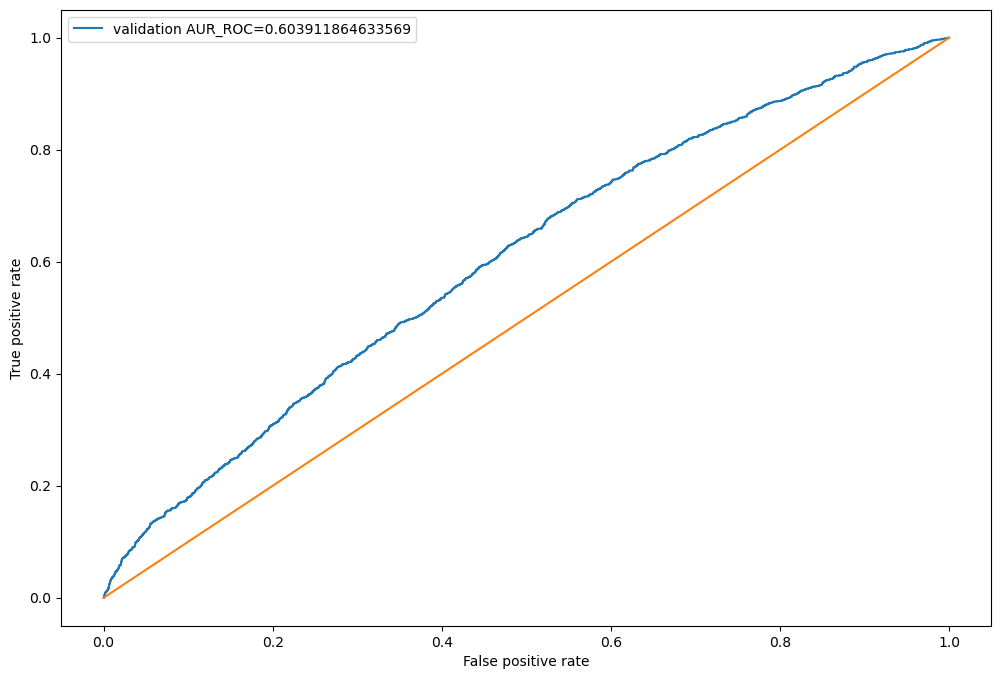

In [86]:

from sklearn.metrics import roc_curve
fpr,tpr, _ =roc_curve(ytest,pred)
auc=roc_auc_score(ytest,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label='validation AUR_ROC='+str(auc))
x=np.linspace(0,1,1000)
plt.plot(x,x,linestyle='-')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(loc='best')
plt.show()

In [87]:
pred_val=model.predict(xtest)


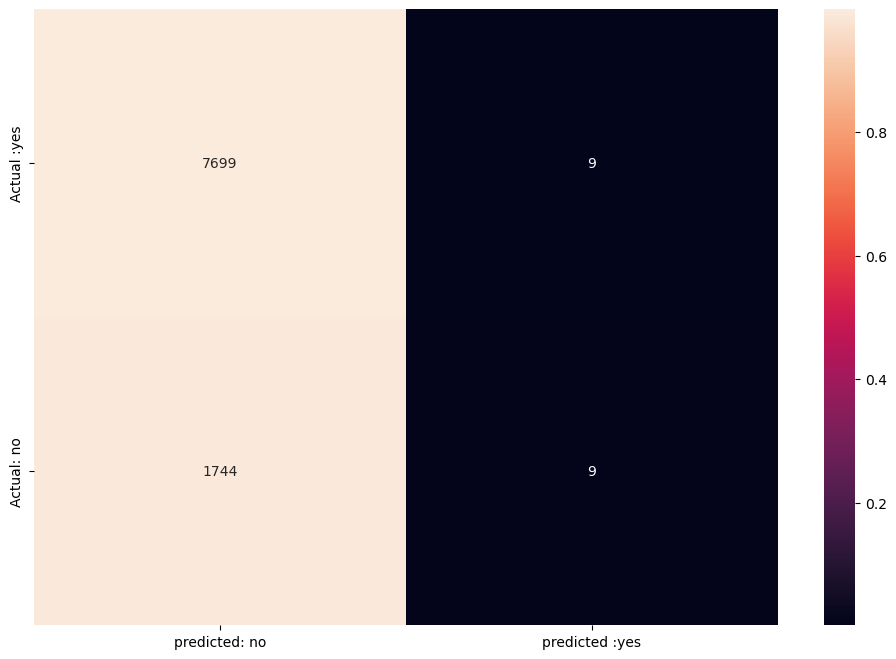

In [89]:
label_preds=pred_val
cm=confusion_matrix(ytest,label_preds)

def plot_confusion_matrix(cm,normalized=True,cmp='bone'):
    
    plt.figure(figsize=(12,8))
    norm_cm=cm
    if normalized:
        norm_cm=cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
        sns.heatmap(norm_cm,annot=cm,fmt='g',xticklabels=['predicted: no','predicted :yes'],yticklabels=['Actual :yes','Actual: no'])
plot_confusion_matrix(cm,['No','Yes'])

In [90]:
recall_score(ytest,pred_val)

0.00513405590416429

# cross validation


In [91]:
def cv_score(ml_model,rstate=11, thres=0.5,cols=df.columns):
    cv_score=[]
    df1=df.copy()
    df1=df[cols]
    
    #5 fold cross validation
    kf=StratifiedKFold(n_splits=5,random_state=rstate,shuffle=True)
    for df_index,test_index in kf.split(df1,y_all):
        print('\n{} of kfold {}'.format(i,kf.n_splits))
        xtr,xvl =df1.loc[df_index],df1.loc[test_index]
        ytr,yvl=y_all.loc[df_index],y_all[test_index]
        
        
        model=ml_model
        model.fit(xtr,ytr)
        pred_probs=model.predict_proba(xvl)
        pp=[]
        
        for j in pred_probs[:,1]:
            if j>thres:
                pp.append(1)
            else:
                pp.append(0)
                
        pred_val=pp
        roc_score=roc_auc_score(yvl,pred_probs[:,1])
        recall=recall_score(yvl,pred_val)
        precision=precision_score(yvl,pred_val)
        sufix=""
        msg=""
        msg+="Roc Auc Score:{} ,recall score:{:.4f},precision score {:4f}".format(roc_score,recall,precision)
        print("{}".format(msg))
        
        cv_score.append(roc_score)
    return cv_score

In [92]:
baseline_scores=cv_score(LogisticRegression(),cols=baseline)
                        



previous_month_balance of kfold 5
Roc Auc Score:0.6094499023738568 ,recall score:0.0057,precision score 0.461538

previous_month_balance of kfold 5
Roc Auc Score:0.5933522762306033 ,recall score:0.0029,precision score 0.300000

previous_month_balance of kfold 5
Roc Auc Score:0.5657806394476825 ,recall score:0.0086,precision score 0.529412

previous_month_balance of kfold 5
Roc Auc Score:0.5952976576170617 ,recall score:0.0038,precision score 0.222222

previous_month_balance of kfold 5
Roc Auc Score:0.5864341647808755 ,recall score:0.0086,precision score 0.391304


In [93]:
all_feat_scores=cv_score(LogisticRegression())


previous_month_balance of kfold 5
Roc Auc Score:0.6069051484945021 ,recall score:0.0067,precision score 0.700000

previous_month_balance of kfold 5
Roc Auc Score:0.6091791182817798 ,recall score:0.0029,precision score 0.375000

previous_month_balance of kfold 5
Roc Auc Score:0.5931630885971029 ,recall score:0.0076,precision score 0.470588

previous_month_balance of kfold 5
Roc Auc Score:0.6135721874301051 ,recall score:0.0057,precision score 0.352941

previous_month_balance of kfold 5
Roc Auc Score:0.5958552748431066 ,recall score:0.0048,precision score 0.294118


In [94]:
#reverse feature elimnation
from sklearn.feature_selection import RFE

model=LogisticRegression()
rfe=RFE(estimator=model,n_features_to_select=1,step=1)
rfe.fit(df,y_all)

RFE(estimator=LogisticRegression(), n_features_to_select=1)

In [95]:
ranking_df=pd.DataFrame()
ranking_df['Feature_name']=df.columns
ranking_df['Rank']=rfe.ranking_

In [96]:
ranked=ranking_df.sort_values(by=['Rank'])
ranked

,Feature_name,Rank
7,occupation_company,1
8,occupation_retired,2
18,previous_month_credit,3
11,occupation_student,4
9,occupation_salaried,5
2,gender,6
3,dependents,7
17,current_month_credit,8
1,age,9
10,occupation_self_employed,10


In [97]:
ref_top_10_scores=cv_score(LogisticRegression(),cols=ranked['Feature_name'][:10].values)


previous_month_balance of kfold 5
Roc Auc Score:0.5769486178193403 ,recall score:0.0029,precision score 0.333333

previous_month_balance of kfold 5
Roc Auc Score:0.5898068030007193 ,recall score:0.0019,precision score 0.200000

previous_month_balance of kfold 5
Roc Auc Score:0.5800861680503112 ,recall score:0.0057,precision score 0.428571

previous_month_balance of kfold 5
Roc Auc Score:0.5935430906034971 ,recall score:0.0029,precision score 0.272727

previous_month_balance of kfold 5
Roc Auc Score:0.5714041963240227 ,recall score:0.0038,precision score 0.363636


In [98]:
result_df=pd.DataFrame({'baseline':baseline_scores,'all_feats':all_feat_scores,'rfe_top_10':ref_top_10_scores})

<AxesSubplot:>

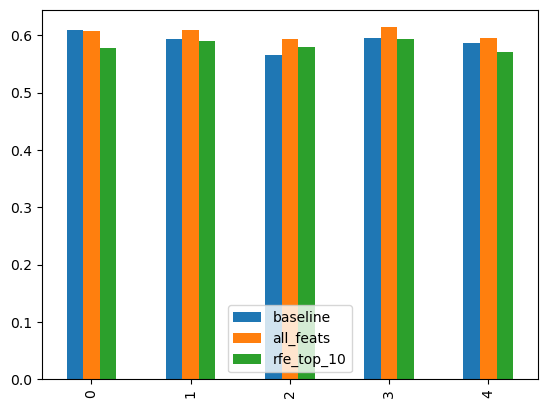

In [99]:
result_df.plot(y=['baseline','all_feats','rfe_top_10'],kind='bar')